# **PRiAD - projekt**

### Skład zepsołu:
* Daria Danieluk
* Kateryna Kononova
* Weronika Zbierowska

## Cel projektu
Projekt polega na wykonaniu analizy zbioru danych CIC-Darnket2020 zawierającego dane o ruchu sieciowym. Celem jest przeprowadzenie 2 rodzajów klasyfikacji: binarnej TOR vs NonTOR oraz klasyfikacji ruchu według rodzaju usługi.

## Opis zbioru danych

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
# wczytanie i dopasowanie danych do wymagań projektowych
cols_list = ['Total Length of Fwd Packet', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Packet Length Min', 'Packet Length Max', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'Label', 'Label.1']
df = pd.read_csv('Darknet.CSV', usecols=cols_list)
df = df.loc[(df['Label'] == 'Tor') | (df['Label'] == 'Non-Tor')]
df.loc[df['Label.1'] == 'AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
df.loc[df['Label.1'] == 'File-transfer', 'Label.1'] = 'File-Transfer'
df.rename(columns={'Label': 'Network Category', 'Label.1': 'Traffic Category'}, inplace=True)
df.head()

,Total Length of Fwd Packet,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count,Network Category,Traffic Category
0,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
1,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
2,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
3,0,0,0,0,0,20,20,0,0,2,0,0,Non-Tor,Audio-Streaming
4,64530,1,0,0,0,11820,8000,0,498,1,0,0,Non-Tor,Audio-Streaming


In [30]:
print("Liczba wierszy = ", df.shape[0])
print("Liczba kolumn = ", df.shape[1])
df.info()

Liczba wierszy =  94748
Liczba kolumn =  14
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94748 entries, 0 to 118610
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Total Length of Fwd Packet  94748 non-null  int64 
 1   Fwd PSH Flags               94748 non-null  int64 
 2   Bwd PSH Flags               94748 non-null  int64 
 3   Fwd URG Flags               94748 non-null  int64 
 4   Bwd URG Flags               94748 non-null  int64 
 5   Fwd Header Length           94748 non-null  int64 
 6   Bwd Header Length           94748 non-null  int64 
 7   Packet Length Min           94748 non-null  int64 
 8   Packet Length Max           94748 non-null  int64 
 9   FIN Flag Count              94748 non-null  int64 
 10  SYN Flag Count              94748 non-null  int64 
 11  RST Flag Count              94748 non-null  int64 
 12  Network Category            94748 non-null  object
 13  T

Wybrana część zbioru danych CIC-Darknet2020 składa się z 94748 wierszy i 14 kolumn - 12 atrybutów opisujących i 2 atrybutów decyzyjnych.

### *[tu wstawić opis kolumn]*

## Analiza ekploracyjna danych

### Braki w danych

In [31]:
print("Liczba brakujących danych = ", df.isnull().sum().sum())

Liczba brakujących danych =  0


W zbiorze nie występują żadne braki w danych.

### Podstawowe statystyki na temat atrybutów opisujących w zbiorze

In [32]:
df.describe()

,Total Length of Fwd Packet,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
count,9.474800e+04,94748.000000,94748.0,94748.0,94748.0,9.474800e+04,9.474800e+04,94748.000000,94748.000000,94748.000000,94748.000000,94748.000000
mean,1.285454e+05,0.120762,0.0,0.0,0.0,2.954200e+03,2.605246e+03,7.753947,333.975208,0.604783,0.627443,0.027367
std,2.305133e+06,0.325853,0.0,0.0,0.0,3.820125e+04,3.005228e+04,17.224699,580.153254,0.566279,0.928077,0.212689
min,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.0,0.0,0.0,2.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000e+01,0.000000,0.0,0.0,0.0,4.000000e+01,2.000000e+01,0.000000,52.000000,1.000000,0.000000,0.000000
75%,4.460000e+02,0.000000,0.0,0.0,0.0,1.120000e+02,9.200000e+01,0.000000,407.250000,1.000000,2.000000,0.000000
max,1.434918e+08,1.000000,0.0,0.0,0.0,2.279200e+06,1.632600e+06,1350.000000,33450.000000,2.000000,3.000000,16.000000


Zakresy wartości poszczególnych atrybutów:
* wartości atrybutu `Total Length of Fwd Packet` zmieniają się w bardzo dużym zakresie, od 0 do rzędu wielkości 10^8
* wartości atrybutów `Fwd Header Length` oraz `Bwd Header Length` zmieniają się w bardzo dużym zakresie, od 0 do rzędu wielkości 10^6
* wartości atrybutu `Packet Length Min` zmieniają się w dużym zakresie, od 0 do rzędu wielkości 10^3
* wartości atrybutu `Packet Length Max` zmieniają się w dużym zakresie, od 0 do rzędu wielkości 10^4
* wartości atrybutów `Bwd PSH Flags`, `Fwd URG Flags` oraz `Bwd URG Flags` są równe 0 dla wszystkich obiektów
* wartości atrybutu `Fwd PSH Flags` przyjmują wartości 0 lub 1
* wartości atrybutu `FIN Flag Count` przyjmują wartości 0, 1 lub 2
* wartości atrybutu `SYN Flag Count` przyjmują wartości 0, 1, 2 lub 3
* wartości atrybutu `RST Flag Count` zmieniają się w zakresie <0, 16>  
  
Jak można zauważyć, w zbiorze danych występują atrybuty o różnych zakresach zmienności, są niewspółmierne. Ich dokładny rozkład zostanie poddany analizie w dalszej części. Atrybuty `Bwd PSH Flags`, `Fwd URG Flags` oraz `Bwd URG Flags` zostaną wykluczone z dalszej analizy - nic do niej nie wnoszą.

In [56]:
df.drop(columns=['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94748 entries, 0 to 118610
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Total Length of Fwd Packet  94748 non-null  int64 
 1   Fwd PSH Flags               94748 non-null  int64 
 2   Fwd Header Length           94748 non-null  int64 
 3   Bwd Header Length           94748 non-null  int64 
 4   Packet Length Min           94748 non-null  int64 
 5   Packet Length Max           94748 non-null  int64 
 6   FIN Flag Count              94748 non-null  int64 
 7   SYN Flag Count              94748 non-null  int64 
 8   RST Flag Count              94748 non-null  int64 
 9   Network Category            94748 non-null  object
 10  Traffic Category            94748 non-null  object
dtypes: int64(9), object(2)
memory usage: 8.7+ MB


### Podstawowe statystyki na temat atrybutów opisujących - porównanie Tor vs Non-Tor

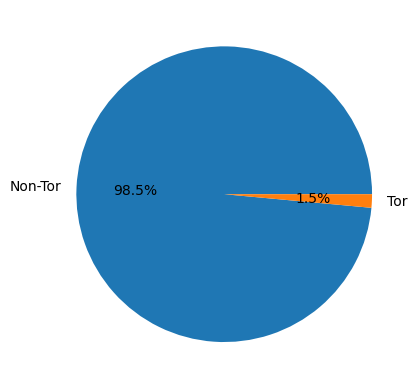

In [57]:
labels = ['Non-Tor', 'Tor']
sizes = [df[df['Network Category'] == 'Non-Tor'].shape[0], df[df['Network Category'] == 'Tor'].shape[0]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.show()

Zbiór danych jest niezbalansowany - obiektów klasy `Non-Tor` jest znacznie więcej niż obiektów klasy `Tor`.

In [58]:
print("Liczba obiektów w klasie Non-Tor = ", df[df['Network Category'] == 'Non-Tor'].shape[0])
df[df['Network Category'] == 'Non-Tor'].describe()

Liczba obiektów w klasie Non-Tor =  93356


,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
count,9.335600e+04,93356.000000,9.335600e+04,9.335600e+04,93356.000000,93356.000000,93356.000000,93356.000000,93356.000000
mean,3.714035e+04,0.113126,1.117060e+03,1.256511e+03,7.828174,319.667981,0.612183,0.635546,0.027561
std,1.087435e+06,0.316749,1.670923e+04,1.924600e+04,17.217206,527.000946,0.565198,0.931203,0.213017
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,2.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000e+01,0.000000,4.000000e+01,2.000000e+01,0.000000,52.000000,1.000000,0.000000,0.000000
75%,4.090000e+02,0.000000,1.120000e+02,9.200000e+01,0.000000,328.000000,1.000000,2.000000,0.000000
max,8.014597e+07,1.000000,1.110420e+06,1.077432e+06,1350.000000,1460.000000,2.000000,2.000000,16.000000


In [59]:
print("Liczba obiektów w klasie Tor = ", df[df['Network Category'] == 'Tor'].shape[0])
df[df['Network Category'] == 'Tor'].describe()

Liczba obiektów w klasie Tor =  1392


,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
count,1.392000e+03,1392.000000,1.392000e+03,1.392000e+03,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000
mean,6.258728e+06,0.632902,1.261640e+05,9.305965e+04,2.775862,1293.505029,0.108477,0.084052,0.014368
std,1.563346e+07,0.482187,2.554321e+05,1.683665e+05,17.001629,1830.630880,0.390966,0.414654,0.189047
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.086000e+03,0.000000,9.600000e+01,9.600000e+01,0.000000,543.000000,0.000000,0.000000,0.000000
50%,1.034085e+05,1.000000,1.629000e+04,3.932000e+04,0.000000,1460.000000,0.000000,0.000000,0.000000
75%,1.705210e+06,1.000000,1.095050e+05,9.442500e+04,0.000000,1460.000000,0.000000,0.000000,0.000000
max,1.434918e+08,1.000000,2.279200e+06,1.632600e+06,191.000000,33450.000000,2.000000,3.000000,3.000000


Obserwując jedynie zakresy wartości poszczególnych atrybutów opisujących można wyciągnąć następujące wnioski:
* obiekty o wartości atrybutu `Total Length of Fwd Packet` > 8.014597e+07 występują jedynie w klasie `Tor`
* atrybuty `Fwd PSH Flags` oraz `FIN Flag Count` nie umożliwiają odróżnienia obiektów klasy `Tor` od obiektów klasy `Non-Tor`
* obiekty o wartości atrybutu `Fwd Header Length` > 1.110420e+06 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `Bwd Header Length` > 1.077432e+06 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `Packet Length Min` > 191 występują jedynie w klasie `Non-Tor`
* obiekty o wartości atrybutu `Packet Length Max` > 1460 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `SYN Flag Count` > 2 występują jedynie w klasie `Tor`
* obiekty o wartości atrybutu `RST Flag Count` > 3 występują jedynie w klasie `Non-Tor`

### Analiza kategorii ruchu

In [60]:
print("Liczba kategorii ruchu = ", len(df.loc[:, 'Traffic Category'].unique()))

Liczba kategorii ruchu =  8


In [61]:
print("Liczba obiektów w danej klasie:")
for k in list(df.loc[:, 'Traffic Category'].unique()):
    print(k, " = ", df[df['Traffic Category'] == k].shape[0])

Liczba obiektów w danej klasie:
Audio-Streaming  =  1708
Browsing  =  32808
Chat  =  478
Email  =  505
File-Transfer  =  6847
P2P  =  48520
Video-Streaming  =  3584
VOIP  =  298


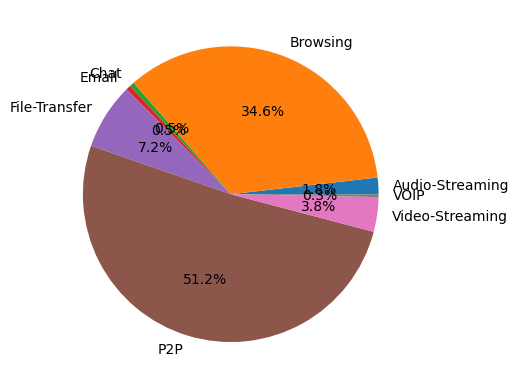

In [62]:
labels = []
sizes = []

for k in list(df.loc[:, 'Traffic Category'].unique()):
    labels.append(k)
    sizes.append(df[df['Traffic Category'] == k].shape[0])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.show()

Liczba obiektów w poszczególnych kategoriach ruchu nie jest równa. Ponad połowa obiektów należy do kategorii `P2P`, a ponad 1/3 do kategorii `Browsing`. Jedynie 15% obiektów należy do pozostałych 6 kategorii.

In [64]:
# może dodać porównanie częstości występowania flag TCP w różnych kategoriach ruchu? TODO
df.groupby('Traffic Category').mean()

,Total Length of Fwd Packet,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Packet Length Min,Packet Length Max,FIN Flag Count,SYN Flag Count,RST Flag Count
Traffic Category,,,,,,,,,
Audio-Streaming,44713.954918,0.283958,7396.238876,8619.440281,7.146370,668.928571,0.295667,0.271663,0.010539
Browsing,2828.127103,0.054133,360.800171,505.794440,11.119117,345.995458,0.608358,0.626189,0.032370
Chat,19553.301255,0.209205,1331.991632,1572.158996,11.577406,545.575314,0.410042,0.368201,0.008368
Email,670976.302970,0.154455,11569.885149,7597.283168,12.419802,463.603960,0.469307,0.475248,0.132673
File-Transfer,842714.009055,0.033153,13090.322185,6402.104863,4.470863,576.196582,0.613407,0.859939,0.127793
P2P,89376.830544,0.168261,2173.794394,2132.459852,5.638994,258.619951,0.630214,0.628854,0.004740
VOIP,821656.697987,0.647651,54568.510067,55347.020134,4.030201,1148.419463,0.167785,0.117450,0.057047
Video-Streaming,365680.043248,0.116908,10488.770089,13153.474330,11.285156,507.517299,0.440011,0.443638,0.089286


### Rozkład wartości atrybutów opisujących w zbiorze danych

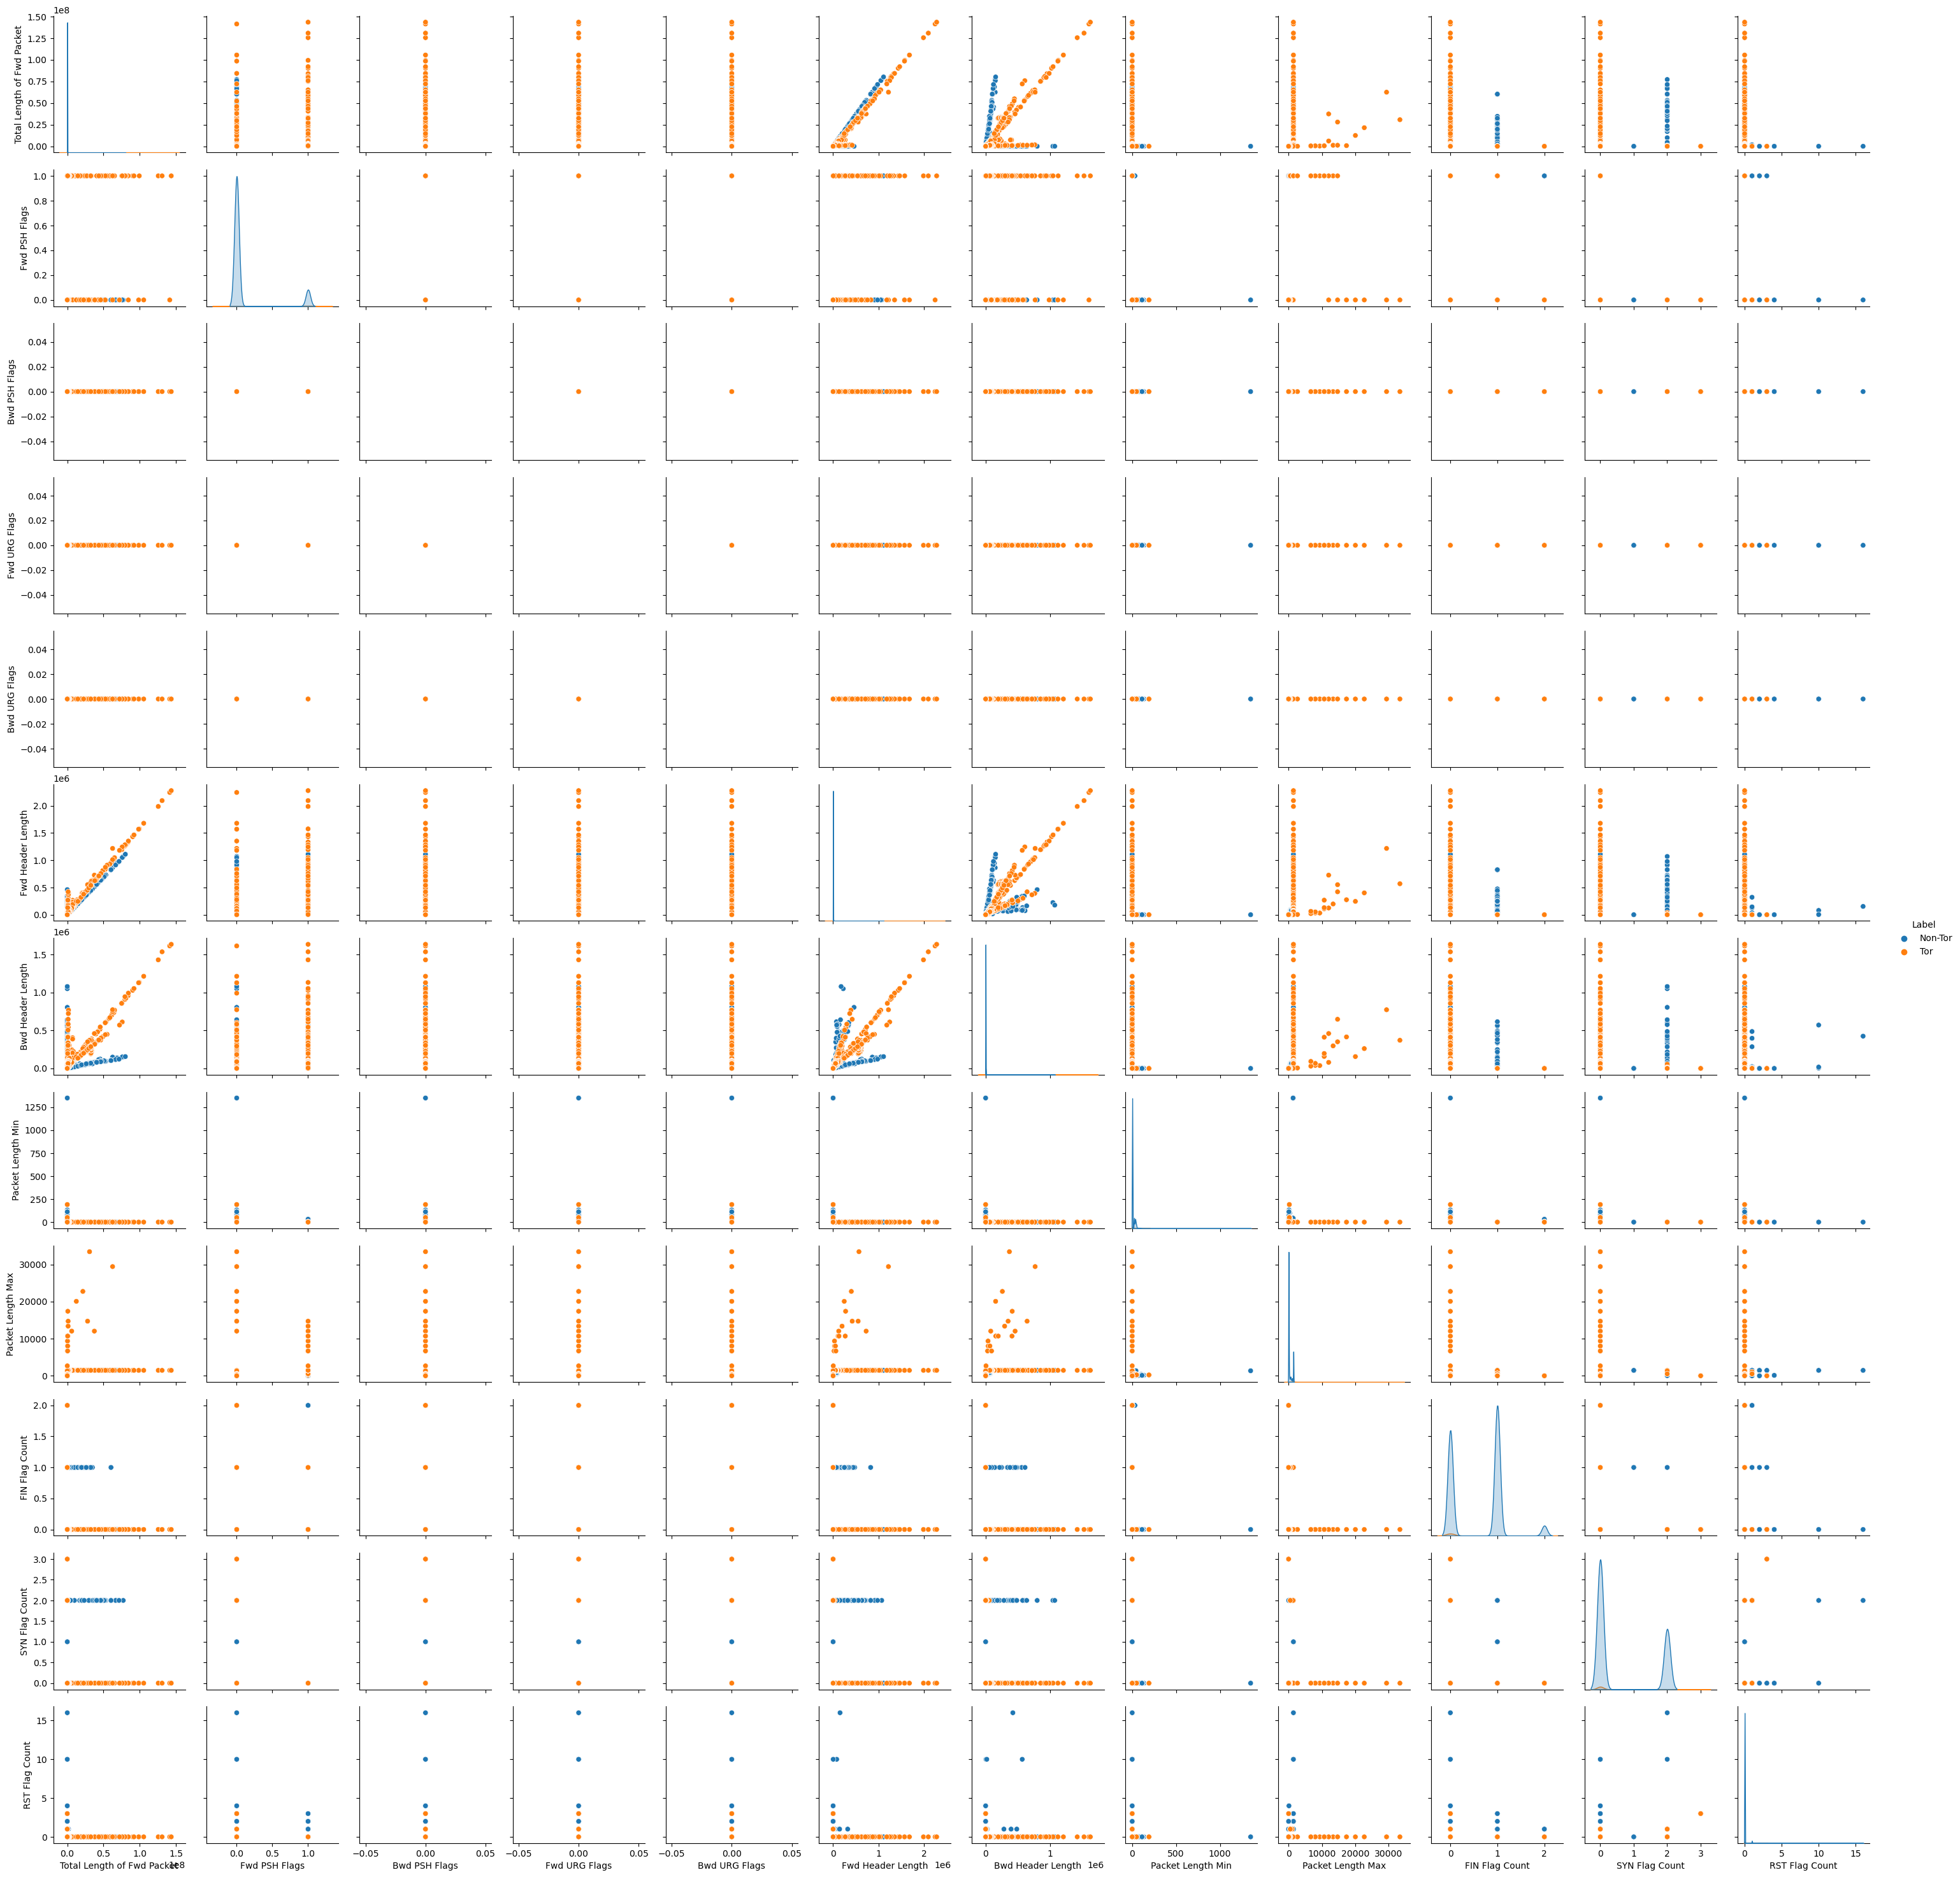

In [20]:
# NIE RUSZAĆ TEGO BLOKU, BO WYGENEROWANIE TEGO ZAJĘŁO BARDZO DUŻO CZASU I RAMU!!!
sns.pairplot(df, kind="scatter", hue="Label")
plt.show()

D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


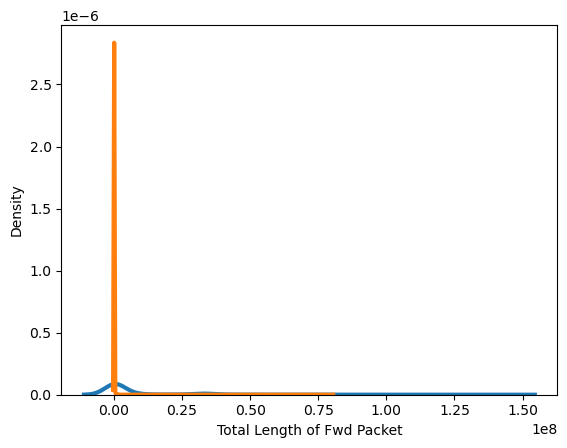

In [41]:
atr = 'Total Length of Fwd Packet'
network_categories = ['Tor', 'Non-Tor']

for k in network_categories:
    subset = df[df['Network Category'] == k]

    sns.distplot(subset[atr], hist = False, kde = True, kde_kws = {'linewidth': 3}, label = k)
    
# Plot formatting
#plt.legend(prop={'size': 16}, title = 'Airline')
#plt.title('Density Plot with Multiple Airlines')
#plt.xlabel('Delay (min)')
#plt.ylabel('Density')

D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\dirto\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total Length of Fwd Packet', ylabel='Density'>

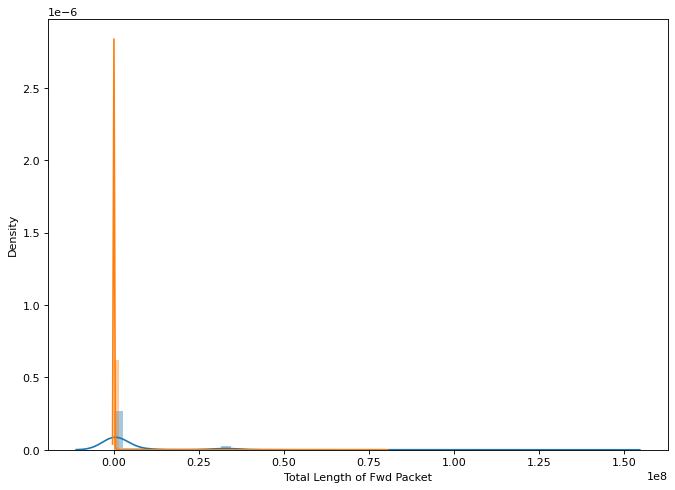

In [37]:
atr = 'Total Length of Fwd Packet'
plt.figure(figsize=(10, 7), dpi=80)
sns.distplot(df.loc[df['Network Category'] == 'Tor', atr], label="Tor")
sns.distplot(df.loc[df['Network Category'] == 'Non-Tor', atr], label="Non-Tor")

<AxesSubplot:ylabel='Frequency'>

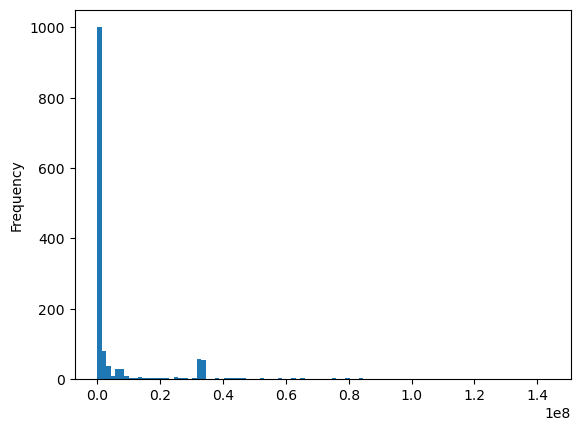

In [38]:
df_tor = df[df['Network Category'] == 'Tor']
df_tor['Total Length of Fwd Packet'].plot.hist(bins=100)

<AxesSubplot:>

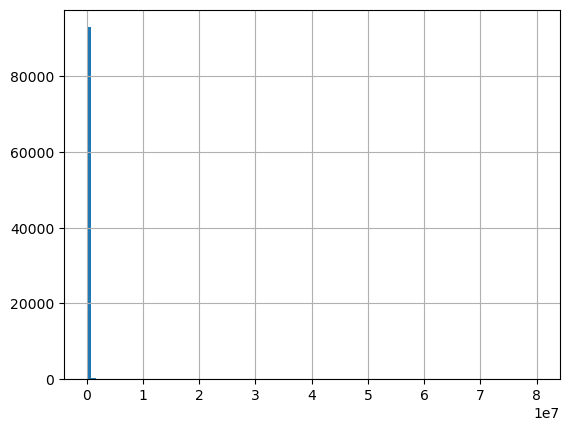

In [39]:
df_nontor = df[df['Network Category'] == 'Non-Tor']
df_nontor['Total Length of Fwd Packet'].hist(bins=100)

<AxesSubplot:>

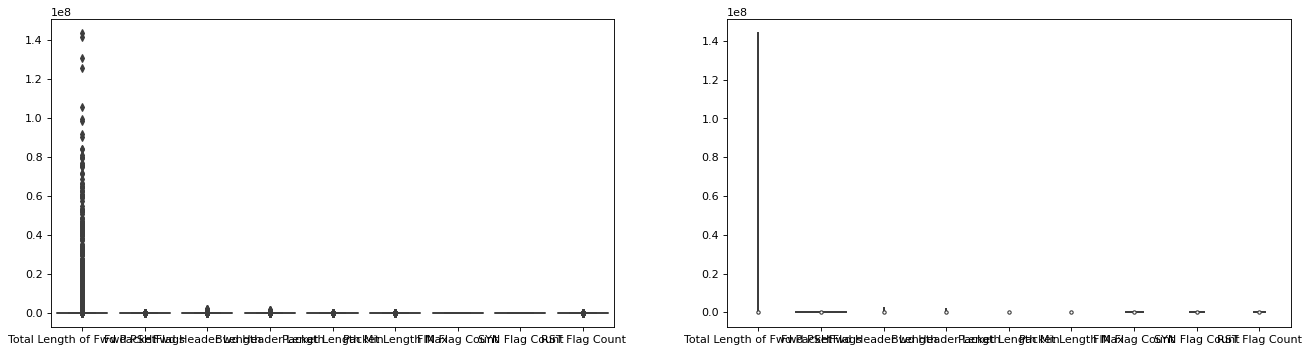

In [65]:
# trzeba jakoś inaczej, bo zakresy są bardzo różne TODO
plt.figure(figsize=(20, 5), dpi=80)
plt.subplot(1, 2, 1)
sns.boxplot(data=df)
plt.subplot(1, 2, 2)
sns.violinplot(data=df)

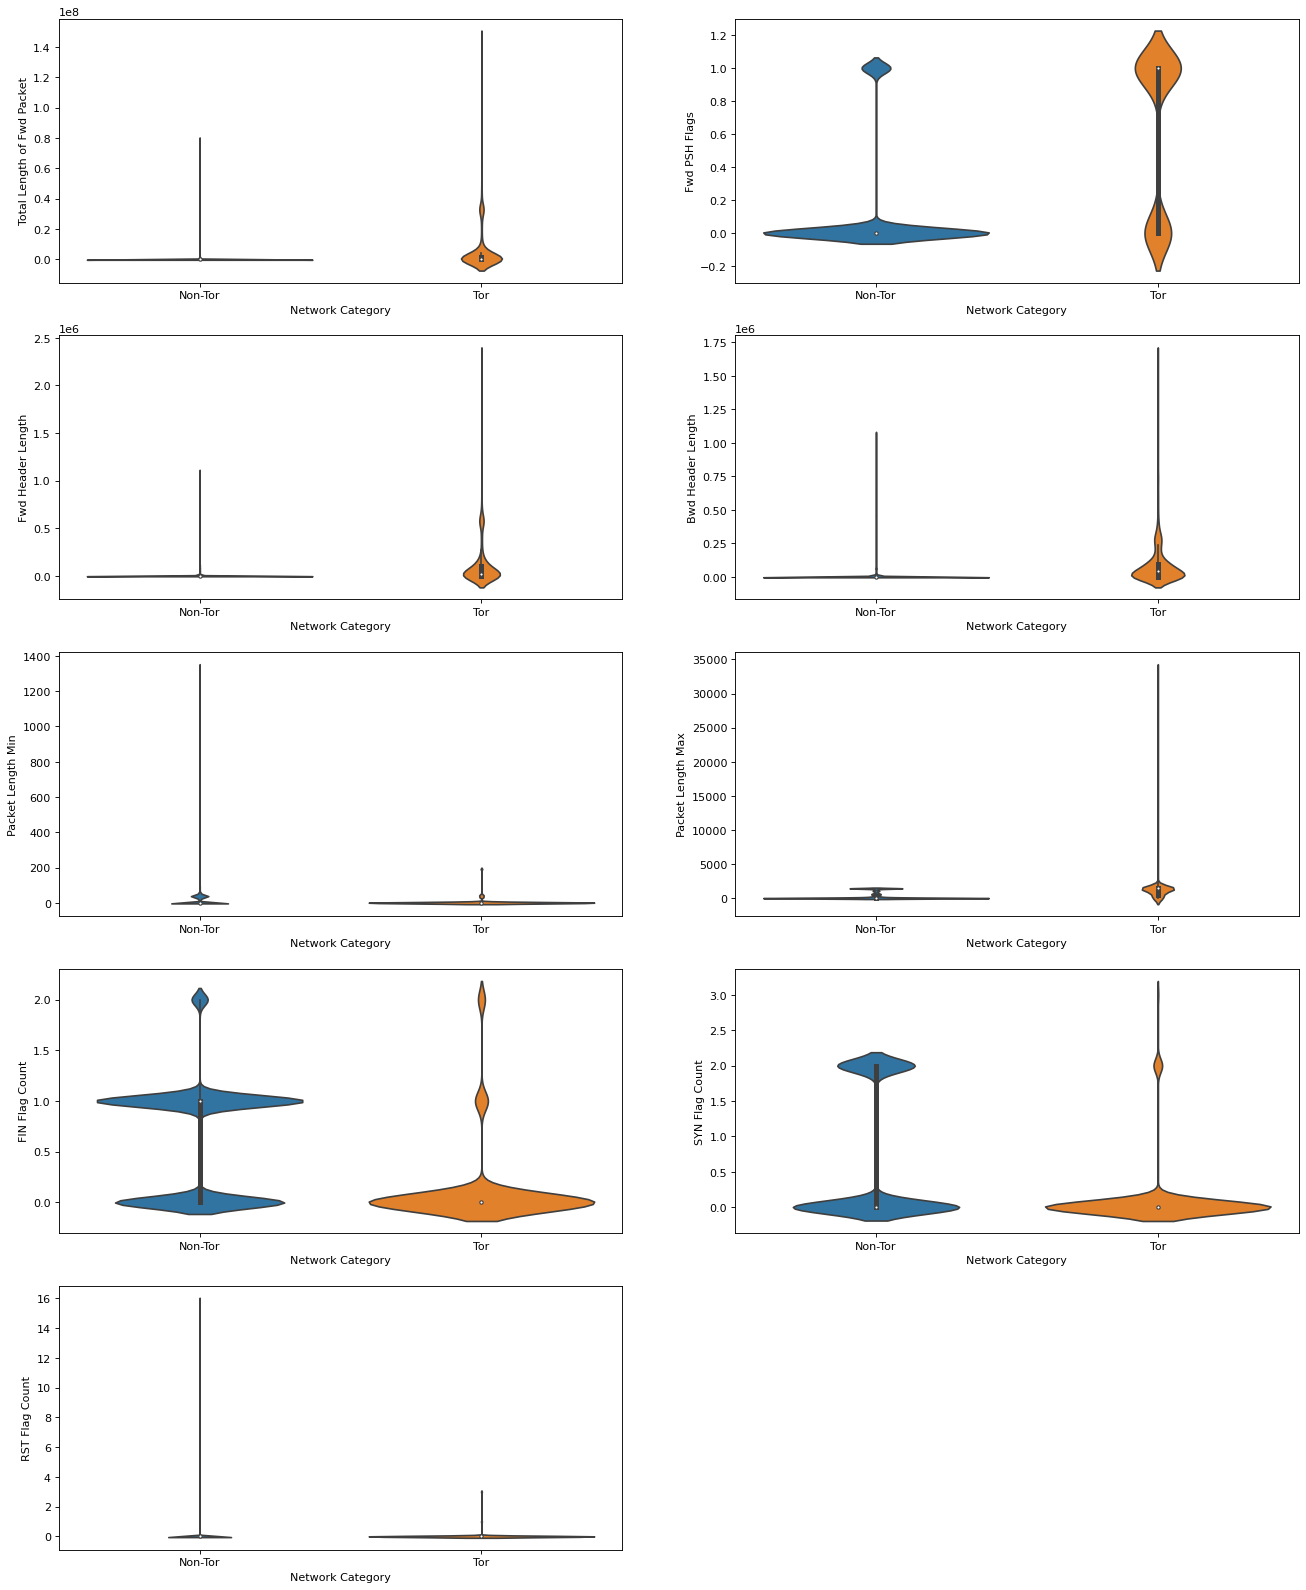

In [66]:
# nie wiem czy to ma sens TODO
plt.figure(figsize=(20, 30), dpi=80)
nr = 1
for atr in df.columns[:-2]:
    plt.subplot(6, 2, nr)
    nr += 1
    sns.violinplot(data=df, x='Network Category', y=atr)

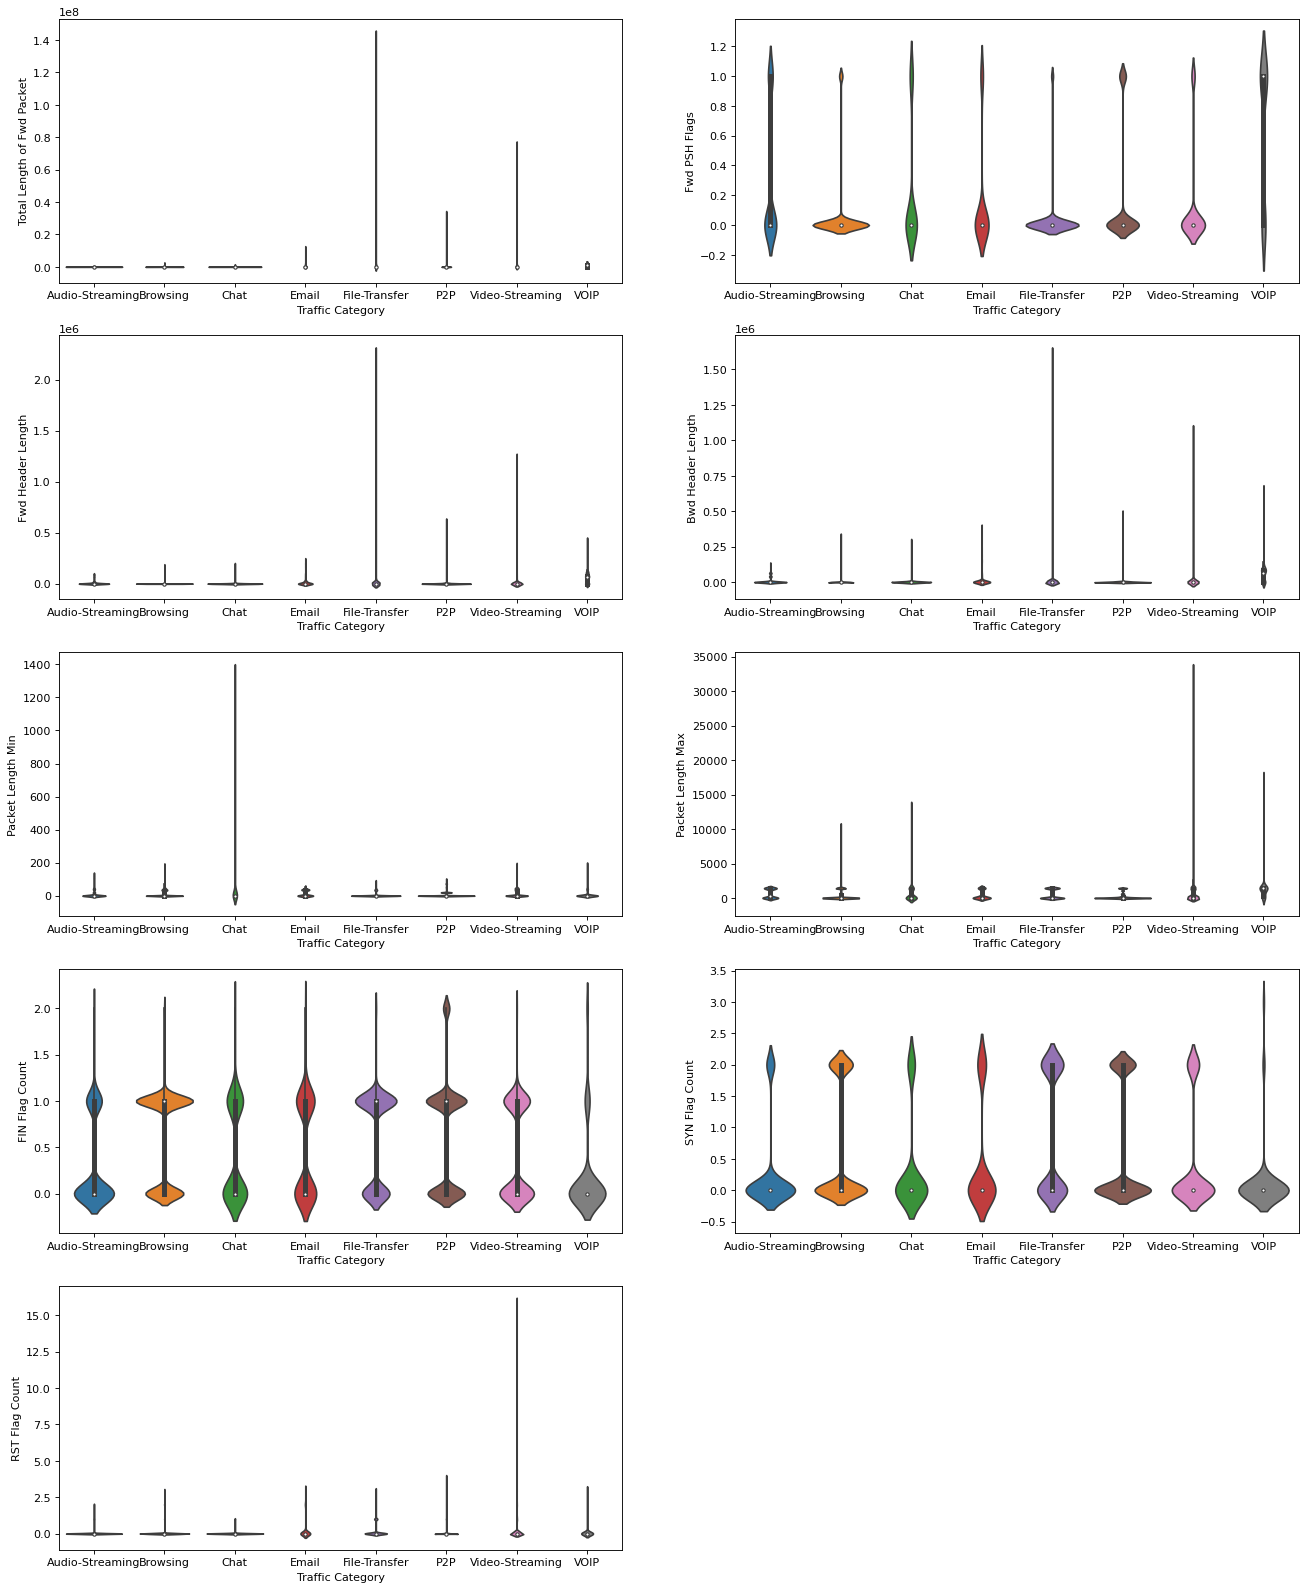

In [67]:
# nie wiem czy to ma sens TODO
plt.figure(figsize=(20, 30), dpi=80)
nr = 1
for atr in df.columns[:-2]:
    plt.subplot(6, 2, nr)
    nr += 1
    sns.violinplot(data=df, x='Traffic Category', y=atr)

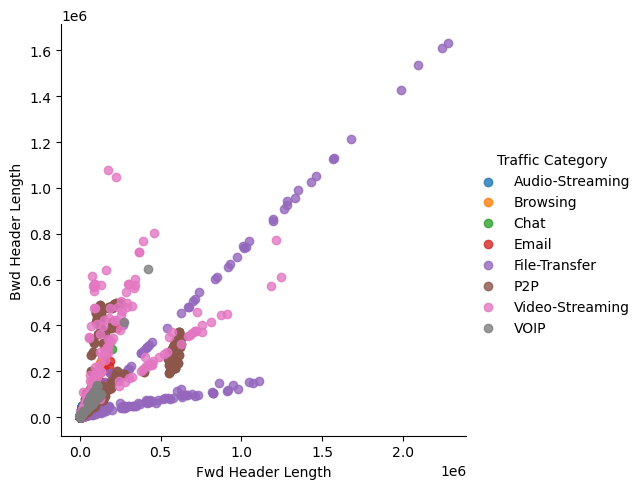

In [50]:
sns.lmplot(x='Fwd Header Length', y='Bwd Header Length', data=df, fit_reg=False, hue='Traffic Category', legend=True)

<AxesSubplot:>

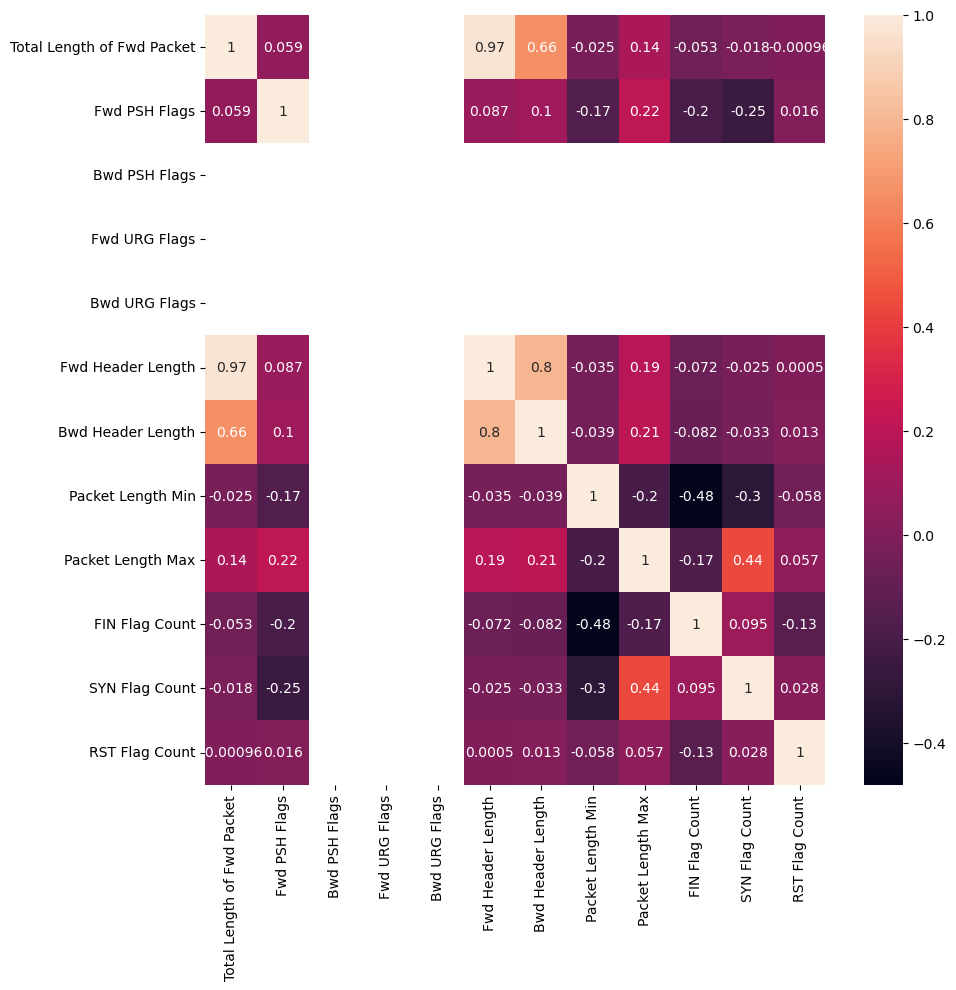

In [51]:
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(df.corr(), annot=df.corr())